__The input file contains the following fields:__

| Name    | Description |
| -------- | ------- |
| UID  | Unique ID of the owning application    |
| DBType | Type of the Databse (MSSQL, MySQL, Oracle, DB2)     |
| Instance    | The instance of the Ddtabase |
| DBName | The name of the database |
| Schema | The schema where the table os located in the database |
| Table | The name of the table |
| Column | The name of a single column |
| ColumnType | The datatyp of the column |

| DB | UID |    DBType | Instance |    DBName |      Schema |      Table |           Column |         ColumnType | 
| ----- | ----- |    ----- | ----- |    ----- |      ----- |      ----- |           ----- |         ----- | 
| __MSSQL__ | UID |    DBType | Instance |    DBName |      Schema |      Table |           Column |         ColumnType | 
| __Oracle__ | uid |   dbtype |   |           dbname |      owner |       table_name |      column_name |     data_type |
| __MySQL__ | uid |    dbtype |    |          dbname |      owner |       table_name |      column_name |     data_type | 
| __FINAL COLUMN NAMES__ | UID | DB_TYPE | _droped_ | DB_NAME | SCHEMA |  TABLE_NAME | COLUMN_NAME | DATA-TYPE | 

In [2]:
!pip install pyLDAvis
!pip install wordninja
!pip install lingua-language-detector

# Prepare the data

we have metadata about MSSQL, Oracle and MySQL Instances in CSV compressed in ZIP files - these CSVs must be merged into the same structure

In [3]:
# remove the existing data files
!rm -f data/*.csv  
!rm -f data/*.dic
!rm -f data/*.txt

# extract the german dictory used for word splitting
!unzip data/german.zip german.dic -d data

# unzip the data files avialable
!unzip -o data/mssql_allprod_collumns.zip -d data/
!unzip -o data/oracle_metadata.zip -d data/
!unzip -o data/mysql_metadata.zip -d data/

zsh:1: no matches found: data/*.txt
Archive:  data/german.zip
  inflating: data/german.dic         
Archive:  data/mssql_allprod_collumns.zip
  inflating: data/mssql_allprod_collumns.csv  
Archive:  data/oracle_metadata.zip
  inflating: data/oracle_metadata.csv  
Archive:  data/mysql_metadata.zip
  inflating: data/mysql_metadata.csv  


In [4]:
%%bash
# Prepare MSSQL data

INPUT_FILE="data/mssql_allprod_collumns.csv"
OUTPUT_FILE="data/mssql_allprod_collumns_no_third_column.csv.tmp"

head -3 $INPUT_FILE

# because the column separator is ',', we need to make sure e.g. `numeric(17,10)` is replaced with `numeric(17;10)` in the csv file
sed -E 's/\(([^)]*),([^)]*)\)/(\1;\2)/g' ${INPUT_FILE} > ${OUTPUT_FILE}
echo "The file ${INPUT_FILE} has been processed and saved as ${OUTPUT_FILE}"

# drop the third column ('Instance') from the csv file (it does not exist in the other files)
# Use awk to drop the third column
awk -F, 'BEGIN {OFS=","} { $3=""; sub(",,", ","); print }' ${OUTPUT_FILE} > ${INPUT_FILE}

rm ${OUTPUT_FILE}

echo "The file ${INPUT_FILE} has been processed, the third column has been removed:"
head -3 $INPUT_FILE

UID,DBType,Instance,DBName,Schema,Table,Column,ColumnType
30230,MSSQL,R0015702\RCHSCOMP02,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int
30230,MSSQL,R0015702\RCHSCOMP02,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int
The file data/mssql_allprod_collumns.csv has been processed and saved as data/mssql_allprod_collumns_no_third_column.csv.tmp
The file data/mssql_allprod_collumns.csv has been processed, the third column has been removed:
﻿UID,DBType,DBName,Schema,Table,Column,ColumnType
30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int
30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int


In [5]:
%%bash
# prepare Oracle data
INPUT_FILE="data/oracle_metadata.csv"
OUTPUT_FILE="data/oracle_metadata.csv.tmp"

# the data of one table contains strange column names, remove its columns
sed '/RFA772203/d' $INPUT_FILE > $OUTPUT_FILE

mv $OUTPUT_FILE $INPUT_FILE
rm -f $OUTPUT_FILE

In [6]:
%%bash
# create the dataset to use for the analysis

# the number of records to use for each DB type, set to '-1' to use all records
NR_OF_RECORDS_EACH=5000

TARGET_FILE="data/db_metadata.csv"
echo "Creating the dataset..."

# drop the first line (column names) from the files (except the one from MSSQL)
tail -n +2 data/oracle_metadata.csv > data/oracle_metadata.csv.tmp
tail -n +2 data/mysql_metadata.csv > data/mysql_metadata.csv.tmp

mv data/oracle_metadata.csv.tmp data/oracle_metadata.csv
mv data/mysql_metadata.csv.tmp data/mysql_metadata.csv

if [ $NR_OF_RECORDS_EACH -gt 0 ]; then
    echo "Creating a small dataset with ${NR_OF_RECORDS_EACH} records of each files"
    head -${NR_OF_RECORDS_EACH} data/mssql_allprod_collumns.csv  >  ${TARGET_FILE}
    head -${NR_OF_RECORDS_EACH} data/oracle_metadata.csv         >> ${TARGET_FILE}
    head -${NR_OF_RECORDS_EACH} data/mysql_metadata.csv          >> ${TARGET_FILE}
else
    echo "Creating a dataset with all records of each files"
    cat data/mssql_allprod_collumns.csv data/oracle_metadata.csv data/mysql_metadata.csv > ${TARGET_FILE}
fi

NR_OF_LINES=$(wc -l ${TARGET_FILE})
echo "new dataset contains ${NR_OF_LINES}"

Creating the dataset...
Creating a small dataset with 5000 records of each files
new dataset contains    15000 data/db_metadata.csv


In [7]:
# Importing the required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
import wordninja
# from nltk.corpus import stopwords

In [8]:
# Load the data
df = pd.read_csv('data/db_metadata.csv')
display(df.head())

# for more flexibility when selecting the data file, we rename the columns to be the same for all
new_column_names = {
    df.columns[0]: 'UID',  
    df.columns[1]: 'DB_TYPE',
    df.columns[2]: 'DB_NAME',
    df.columns[3]: 'SCHEMA',
    df.columns[4]: 'TABLE_NAME',
    df.columns[5]: 'COLUMN_NAME',
    df.columns[6]: 'DATA_TYPE',
}
df.rename(columns=new_column_names, inplace=True)

display(df.head())

,UID,DBType,DBName,Schema,Table,Column,ColumnType
0,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int
1,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int
2,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InDisabledStateMilliseconds,int
3,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InPlannedMaintenanceMilliseconds,int
4,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InUnplannedMaintenanceMilliseconds,int


,UID,DB_TYPE,DB_NAME,SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE
0,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int
1,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int
2,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InDisabledStateMilliseconds,int
3,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InPlannedMaintenanceMilliseconds,int
4,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InUnplannedMaintenanceMilliseconds,int


# Utilities

In [9]:
from lingua import Language, LanguageDetectorBuilder

# build a language detector to detect English and German
langdetector = LanguageDetectorBuilder.from_languages(
        Language.ENGLISH, 
        Language.GERMAN
    ).build()

# function to detect if a word is German
def isGerman(word):
    detected_lang = langdetector.detect_language_of(word)
    if detected_lang == Language.GERMAN:
        return True
    else:
        return False

### Prepare the data

In [10]:
# drop columns of known special tables (e.g. technical tables used by flyway, liquibase, quartz, jobrunr)
df = df[~df['TABLE_NAME'].str.lower().str.contains('flyway') 
        & ~df['TABLE_NAME'].str.lower().str.contains('qrtz')
        & ~df['TABLE_NAME'].str.lower().str.contains('shedlock')
        & ~df['TABLE_NAME'].str.lower().str.contains('jobrunr')]
df = df.drop(df[(df['TABLE_NAME'].str.lower() == 'databasechangelog') | (df['TABLE_NAME'].str.lower() == 'databasechangeloglock')].index)


In [11]:
display(df.head())

,UID,DB_TYPE,DB_NAME,SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE
0,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int
1,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int
2,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InDisabledStateMilliseconds,int
3,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InPlannedMaintenanceMilliseconds,int
4,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InUnplannedMaintenanceMilliseconds,int


TODO:
- ~~also remove all numbers from the text~~
- ~~lowercase the text~~
- ~~add table name to DOCUMENT_CONTENT~~
- ~~german vs english~~
~~'CMZKE_KUNDE' -> KUN, should be: KUNDE~~
- german to english translation
- lemmatizing ([germalemma](https://github.com/WZBSocialScienceCenter/germalemma))

In [12]:

# function to split a string into words and filter out short words (less than 4 characters) and numbers
def splitToWordsAndFilter(x):
    if pd.notnull(x) and x:
        if isGerman(x):
            # currrntly we don't have a German word-splitter, so we at least use the underscore to split the words
            words = x.split('_')
        else:
            words = wordninja.split(x)
        return ' '.join([word.lower() for word in words if len(word) > 3 and not word.isdigit()])
    return ''

# split the column names 
df['DOCUMENT_CONTENT'] = df['COLUMN_NAME'].apply(
    lambda x: splitToWordsAndFilter(x)
)

# - Concatenate 'COLUMN_NAME' values for rows with the same 'DB_NAME'/'TABLE_NAME' combination
# - lowercase the text
df_grouped = df.groupby(['UID', 'DB_TYPE', 'DB_NAME', 'TABLE_NAME'])['DOCUMENT_CONTENT'].agg(
    lambda x: ' '.join(x.str.lower())
).reset_index()


df_grouped['TABLE_NAME_CONTENT'] = df_grouped['TABLE_NAME'].apply(
    # don't fail if resulting string is empty
    lambda x: splitToWordsAndFilter(x)
)

df_grouped['DOCUMENT_CONTENT'] = df_grouped['TABLE_NAME_CONTENT'] + ' ' + df_grouped['DOCUMENT_CONTENT']


In [13]:
display(df_grouped.head())

,UID,DB_TYPE,DB_NAME,TABLE_NAME,DOCUMENT_CONTENT,TABLE_NAME_CONTENT
0,100,Oracle,PCRMA01,ADVISORYOUTPUT_2,advisory output financial analysis modified m...,advisory output
1,100,Oracle,PCRMA01,BAK_PRICING_2,pricing deleted frozen modified modifieddate...,pricing
2,100,Oracle,PCRMA01,CMZKE_KUNDE,cmzke kunde changed changed created created do...,cmzke kunde
3,100,Oracle,PCRMA01,CREDITWORTHINESSINDICATORS_2,credit worthiness indicators modified modifie...,credit worthiness indicators
4,100,Oracle,PCRMA01,DEBTCAPACITY_IFBC_2,debt capacity financial analysis modified mod...,debt capacity


In [14]:
# write a CSV with the table names and their split names
df_grouped[['TABLE_NAME', 'TABLE_NAME_CONTENT']].to_csv('table_name_content.csv', index=False)

### Split training data

In [15]:
from sklearn.model_selection import train_test_split 
import numpy as np

# Split the data into train, validation, and test sets, but as we don't the target values, we just fill it with zeros
X_trainval, X_test, y_trainval, y_test = train_test_split(df_grouped, np.zeros(len(df_grouped)), test_size=0.2, random_state=42)

print(len(X_trainval), len(X_test))
display(X_trainval.head())
display(X_test.head())

1118 280


,UID,DB_TYPE,DB_NAME,TABLE_NAME,DOCUMENT_CONTENT,TABLE_NAME_CONTENT
48,106,Oracle,PNMAT01,ADR02_ADDRESSUSAGE,address usage addressee remark address usage t...,address usage
155,106,Oracle,PNMAT01,IST03_DERIVINSTRREL,ivins conversionend conversionstart exercise q...,ivins
756,2004,MySQL,peamintegration,PersonSystem,person system email governance hopexid mitarbe...,person system
1070,30768,MSSQL,WSI_SemperisDSP04_P,tblAdProcessing,processing adprocessingstateid syncandprocessc...,processing
303,106,Oracle,PNMAT01,PLG02_BAPRFLANDGELDFLCATTAGS,plg02 baprflandgeldflcattags plg01 basicpruefl...,plg02 baprflandgeldflcattags


,UID,DB_TYPE,DB_NAME,TABLE_NAME,DOCUMENT_CONTENT,TABLE_NAME_CONTENT
78,106,Oracle,PNMAT01,CFG04_LOGS,cfg04 logs code component time logtype messag...,cfg04 logs
478,106,Oracle,PNMAT01,UEX01_MAN_WCLID,modified date modified user untersuchungsdat...,
354,106,Oracle,PNMAT01,RAM20_RUNNERHEARTBEAT,runner heartbeat last beat name promised inte...,runner heartbeat
594,330,MSSQL,IAM_1IMRecent_P,AADBaseTreeHasDirectoryRole,base tree directory role directory role xdate...,base tree directory role
1255,31326,MSSQL,ABW_GIM_P01,AG2_QUEUE_HOUR,queue hour date time group combination resourc...,queue hour


### Calculate TF-IDF

In [16]:
from spacy.lang.de.stop_words import STOP_WORDS as de_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

# some custom stop words
custom_stop_words = ['item', 'name', 'type', 'code', 'id', 'key', 'value', 'date', 'time', 'status', 'flag', 'description', 'comment', 'number', 'size', 'length', 'version', 'order', 'count', 'level', 'class', 'group', 'status', 'state', 'row', 'str', 'vid', 'ext', 'set', 'rid']

# we have english and german words in the data set, so combine the stop words of both languages
final_stopwords_list = list(de_stop) + list(en_stop) + custom_stop_words

print(len(final_stopwords_list))

899


In [17]:

# Create a document-term matrix using TF-IDF
vectorizer = TfidfVectorizer(stop_words=final_stopwords_list, min_df=4, max_df=0.75, max_features=5000)
doc_term_matrix = vectorizer.fit_transform(df_grouped['DOCUMENT_CONTENT'].values)

print(doc_term_matrix.shape)

(1398, 763)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [18]:
num_clusters = 5

lda = LatentDirichletAllocation(n_components=num_clusters, learning_method='online', random_state=42)
doc_cluster_matrix = lda.fit_transform(doc_term_matrix)

col_names = ['Cluster' + str(i) for i in range(num_clusters)]

doc_cluster_df = pd.DataFrame(doc_cluster_matrix, columns=col_names)
display(doc_cluster_df.head()) 


,Cluster0,Cluster1,Cluster2,Cluster3,Cluster4
0,0.055637,0.056246,0.776830,0.055634,0.055652
1,0.059014,0.059685,0.763268,0.058987,0.059046
2,0.069636,0.070850,0.706954,0.082449,0.070111
3,0.059082,0.059688,0.763904,0.058653,0.058672
4,0.053067,0.053773,0.787316,0.052915,0.052929


In [ ]:
#Visualize reuslts (using https://panel.holoviz.org/)
import pyLDAvis
import pyLDAvis.lda_model

prepared_data = pyLDAvis.lda_model.prepare(lda, doc_term_matrix, vectorizer, mds='tsne', sort_topics=False, n_jobs = -1)
word_info = prepared_data.topic_info

pyLDAvis.enable_notebook()
pyLDAvis.display(prepared_data)    

# To save the result as standaline HTML 
# panel_output = 'panel.html'
# pyLDAvis.save_html(prepared_data, panel_output)
# print(f'Panel saved to {panel_output}')

Panel saved to panel.html


In [20]:
#Print top 30 keywords
for topic in word_info.loc[word_info.Category != 'Default'].Category.unique():
    print(topic)
    print(word_info.loc[word_info.Category.isin([topic])].sort_values('logprob', ascending = False).Term.values[:30])
    print()

Topic1
['element' 'partition' 'milliseconds' 'pruefperson' 'quantity' 'message'
 'rate' 'price' 'account' 'alias' 'bank' 'scope' 'access' 'data'
 'position' 'execution' 'device' 'pwc01' 'product' 'bezeichnung'
 'property' 'contract' 'request' 'interval' 'maintenance' 'attributes'
 'health' 'merge' 'valid' 'market']

Topic2
['created' 'user' 'object' 'modified' 'host' 'entity' 'data' 'attribute'
 'lock' 'rule' 'file' 'text' 'fact' 'resource' 'content' 'active' 'audit'
 'elementname' 'elementvalue' 'timestamp' 'token' 'work' 'definition'
 'document' 'lastmodifieddate' 'session' 'entry' 'instance' 'source'
 'username']

Topic3
['updated' 'partner' 'data' 'source' 'service' 'datum' 'created' 'valid'
 'modifieddate' 'modified' 'dates' 'product' 'virtual' 'dtdate' 'deletion'
 'touched' 'relationship' 'xdateinserted' 'inserted' 'marked' 'rest'
 'system' 'xmldata' 'arrangement' 'business' 'active' 'release' 'deleted'
 'calculated' 'currency']

Topic4
['event' 'lifecycle' 'asset' 'client' 'disp

In [21]:
# Define the number of clusters
num_clusters = 5

# Create a KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the document-term matrix
kmeans.fit(doc_term_matrix)

# Get the cluster labels
kmeans_labels = kmeans.labels_

# Add the cluster labels to the dataframe
df_grouped['KMeans_Cluster'] = kmeans_labels

# Display the first few rows of the dataframe with the new cluster labels
display(df_grouped.head())

,UID,DB_TYPE,DB_NAME,TABLE_NAME,DOCUMENT_CONTENT,TABLE_NAME_CONTENT,KMeans_Cluster
0,100,Oracle,PCRMA01,ADVISORYOUTPUT_2,advisory output financial analysis modified m...,advisory output,2
1,100,Oracle,PCRMA01,BAK_PRICING_2,pricing deleted frozen modified modifieddate...,pricing,2
2,100,Oracle,PCRMA01,CMZKE_KUNDE,cmzke kunde changed changed created created do...,cmzke kunde,2
3,100,Oracle,PCRMA01,CREDITWORTHINESSINDICATORS_2,credit worthiness indicators modified modifie...,credit worthiness indicators,2
4,100,Oracle,PCRMA01,DEBTCAPACITY_IFBC_2,debt capacity financial analysis modified mod...,debt capacity,2


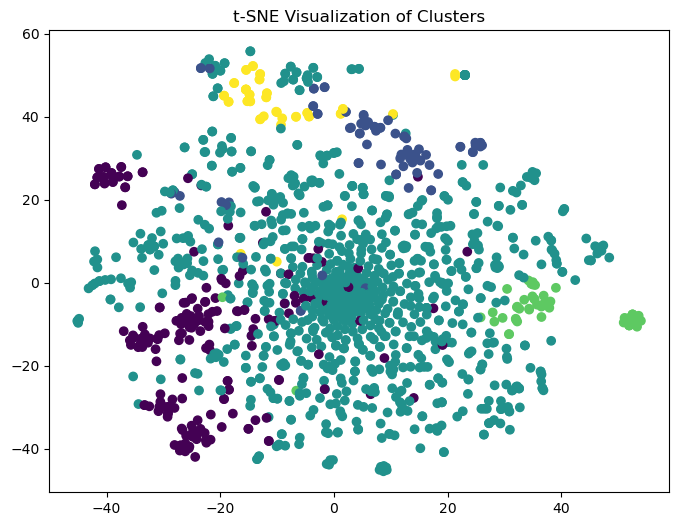

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, init="random")
X_tsne = tsne.fit_transform(doc_term_matrix)

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('t-SNE Visualization of Clusters')
plt.show()